In [1]:
%load_ext autoreload
%autoreload 2
from analysis_settings import *
from plot_settings import *
from scripts.utils_plot import convert_pvalue_to_asterisks, _save_fig, _axes2d
from scripts.utils import _corr_results, _average_hemispheres
from matplotlib.patches import Patch
import numpy as np

# Show both, highlight pooled datasets

In [2]:
# n_perm = None
n_perm = 10000

In [3]:
ch_choice = 'ch_dist_sweet'
dataframes = get_dfs(ch_choice, equalize_subjects_norm_abs=True)

c_abs = cfg.COLOR_DIC['absolute']
c_per = cfg.COLOR_DIC['periodic']
c_ap = cfg.COLOR_DIC['periodicAP']
c_norm = cfg.COLOR_DIC['normalized']
c_insig = 'grey'

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

In [4]:
def _correct_sample_size(df, x, repeated_m="subject"):
    """Remove subjects with less than 2 values for x, y, and hue."""
    if repeated_m == 'project':
        return df
    df_copy = df.dropna(subset=[x, repeated_m]).copy()

    # remove subjects with only one hemisphere
    group = [repeated_m]
    hemis_subject = df_copy.groupby(group).ch_hemisphere.nunique()
    hemi_both = hemis_subject == df_copy.ch_hemisphere.nunique()
    df_copy = df_copy.set_index(group)[hemi_both].reset_index()
    # assert no subjects with only one hemisphere
    enough_subs = (df_copy.groupby(repeated_m).ch_hemisphere.nunique() == 2).all()
    if not enough_subs:
        return None
    # assert (df_copy.groupby(repeated_m).ch_hemisphere.nunique() == 2).all()
    # assert (df_copy.groupby(repeated_m).ch_hemisphere.value_counts() == 1).sum()

    # filter subjects with less than 2 values for x, y, and hue
    df = df[df.subject.isin(df_copy.subject.unique())]
    return df


def _rank_df(df, rank_cols, repeated_m="subject", remove_ties=True):
    """Convert float values for x and y to rank integers.

    Follows rank repeated measures in
    Donna L. Mohr & Rebecca A. Marcon (2005) Testing for a  ‘within-subjects’
    association in repeated measures data, Journal of Nonparametric Statistics,
    17:3, 347-363, DOI: 10.1080/10485250500038694
    """
    # Function to filter out tied ranks
    def remove_ties(df, rank_column):
        return df[df[rank_column] == df[rank_column].astype(int)]

    df = df.copy()
    for cond in ['off', 'on']:
        for x in rank_cols:
            df_rank = df.copy()  # initialize always new in case removing ties yields empty df
            df_rank_cond = df_rank[df_rank.cond == cond]
            df_rank_cond = _correct_sample_size(df_rank_cond, x, repeated_m=repeated_m)
            df_rank_cond[x + '_rank'] = df_rank_cond.groupby(repeated_m)[x].rank()
            if remove_ties:
                df_rank_cond = remove_ties(df_rank_cond, x + '_rank')
            df.loc[(df.cond == cond), x + '_rank'] = df_rank_cond[x + '_rank']
    return df


def _combine_bands(df, cols, func=np.sum):
    df = df.copy()
    combined = '+'.join(cols) + '_rank'
    df[combined] = func(df[cols], 1)
    return df, combined

In [5]:
def get_correlation_df_multi(dataframes,
                             kinds=['normalized', 'absolute', 'periodic'],
                             corr_methods=['spearman', 'withinRank'],
                            #  asymmetric_subjects=True,
                            remove_ties=True,
                             project='all', bands=BANDS,
                             conds=['off', 'on'], n_perm=10000):
    """Get dataframe to plot barplot."""
    plot_dic = cfg.PLOT_LABELS_SHORT
    # plot_dic_long = cfg.PLOT_LABELS
    band_dic = cfg.BAND_NAMES_GREEK_SHORT

    df_corrs = []
    for kind in kinds:
        if kind == 'normalized':
            df = dataframes['df_norm'].copy()
            df = df[(df.project == 'all')]
            # remove subject where asymmetry switches between On and Off
            # if asymmetric_subjects is not None:
            #     df = df[df.asymmetric_subjects == asymmetric_subjects]

            # Important: Use 1 Hz maximum for this figure for better comparison
            # with absolute and normalized. Use 5 Hz for last figure only.
            # band_cols = [f'{band}_abs_max5Hz_log' for band in bands]
            # band_cols = [f'{band}_abs_max_log' for band in bands]
            band_cols = [f'{band}_abs_mean_log' for band in bands]
            band_nmes = [band_dic[band] for band in bands]
        elif kind == 'absolute':
            df = dataframes['df_abs'].copy()
            df = df[(df.project == 'all') & df.fm_exponent.notna()]
            # remove subject where asymmetry switches between On and Off
            # if asymmetric_subjects is not None:
            #     df = df[df.asymmetric_subjects == asymmetric_subjects]
            # band_cols = [f'{band}_abs_max5Hz_log' for band in bands]
            # Important: Use 1 Hz maximum for this figure for better comparison
            # with absolute and normalized. Use 5 Hz for last figure only.
            # band_cols = [f'{band}_abs_max_log' for band in bands]
            band_cols = [f'{band}_abs_mean_log' for band in bands]
            band_nmes = [band_dic[band] for band in bands]
            # band_cols += [f'{band}_abs_max5Hz_log' for band in ['gamma_mid']]
            # band_nmes += [plot_dic_long[band_cols[-1]]]
            # # Add combined feature
            # rank_cols = ['alpha_abs_min_log', 'gamma_mid_abs_mean_log',
            #              'alpha_abs_max5Hz_log', 'gamma_mid_abs_max5Hz_log',
            #              'UPDRS_III', 'UPDRS_bradyrigid_contra']
            # df = _rank_df(df, rank_cols)
            # df, combined = _combine_bands(df, ['alpha_abs_min_log', 'gamma_mid_abs_mean_log'], np.sum)
            # band_cols += ['alpha_abs_min_log', 'gamma_mid_abs_mean_log', combined]
            # band_nmes += ['A min.', 'Gamma Mean',
            #               'A+M']
            # df, combined = _combine_bands(df, ['alpha_abs_max5Hz_log', 'gamma_mid_abs_max5Hz_log'], np.sum)
            # band_cols += [combined]
            # band_nmes += ['A+M Peak']
        elif kind == 'periodic':
            df = dataframes['df_per'].copy()
            df = df[(df.project == 'all')]
            # remove subject where asymmetry switches between On and Off
            # if asymmetric_subjects is not None:
            #     df = df[df.asymmetric_subjects == asymmetric_subjects]
            # remove subjects without fooof fit
            # subs_no_fit = df[df.fm_has_model.isna()].subject.unique()
            # df = df[~df.subject.isin(subs_no_fit)]
            # band_cols = [f'{band}_fm_powers_max_log' for band in bands]
            band_cols = [f'{band}_fm_mean_log' for band in bands]
            band_nmes = [band_dic[band] for band in bands]
        elif kind == 'periodicAP':
            # Add combined feature
            # rank_cols = ['fm_exponent', 'fm_offset_log', 'UPDRS_III', 'UPDRS_bradyrigid_contra']
            # df = _rank_df(df, rank_cols)
            # df, combined = _combine_bands(df, ['fm_exponent_rank', 'fm_offset_log_rank'], np.diff)


            # Add apperiodic power
            def ap_pwr(df, f_low=5, f_high=95):
                # fm limits all projects
                ap_pwr = df.fm_psd_ap_fit_log
                freqs = df.fm_freqs
                mask = (freqs >= f_low) & (freqs <= f_high)
                return ap_pwr[mask].sum()
            # df_per = df_abs.dropna(subset=['fm_has_model', 'fm_psd_ap_fit_log'])
            df['ap_power'] = df.apply(ap_pwr, f_low=1, f_high=60, axis=1)

            band_cols = ['fm_exponent', 'fm_offset_log', 'ap_power'
                        #   combined
                          ]
            band_nmes = ['1/f exponent',
                         plot_dic['fm_offset_log'],
                         'Ap. pwr. 1-60 Hz'
                        #  r'Ap. pwr. $\sum_{1 Hz}^{60 Hz}$'
                        #  r'Ap. pwr. $\int_{1 Hz}^{60 Hz}$'
                        #   'Offset \n- 1/f'
                          ]

        assert len(band_cols) == len(band_nmes), f'{set(band_cols) - set(band_nmes)}'

        for cond in conds:
            df_cond = df[df.cond == cond]

            if cond == 'on':
                # only include consistent asymmetry for ON subjects to
                # exclude possible LDOPA side effects
                df_cond = df_cond[df_cond.dominant_side_consistent]


            # remove subject with only one condition
            subject_counts = df_cond.subject.value_counts()
            valid_subjects = subject_counts[subject_counts == 2].index
            df_cond = df_cond[df_cond.subject.isin(valid_subjects)]
            for i, x in enumerate(band_cols):
                if 'offset' in x or 'exponent' in x:
                    color = cfg.COLOR_DIC['periodicAP'] if cond == 'off' else cfg.COLOR_DIC['periodicAP2']
                else:
                    color = cfg.COLOR_DIC[kind] if cond == 'off' else cfg.COLOR_DIC[f'{kind}2']
                for corr_method in corr_methods:
                    if corr_method == 'spearman':
                        use_corr_method = corr_method
                        y = 'UPDRS_III'
                        df_rho = _average_hemispheres(df_cond, x, y)
                    elif corr_method == 'withinRank':
                        df_rho = df_cond
                        if '_rank' in x:
                            # use within method for ranked data
                            use_corr_method = 'within'
                            y = 'UPDRS_bradyrigid_contra_rank'
                        else:
                            use_corr_method = corr_method
                            y = 'UPDRS_bradyrigid_contra'
                    corr_kwargs = dict(df_rho=df_rho, x=x, y=y,
                                       remove_ties=remove_ties,
                                    corr_method=use_corr_method, n_perm=n_perm)
                    rho, sample_size, label, _, _ = _corr_results(**corr_kwargs)
                    if rho is None:
                        raise ValueError(f'No correlation found for {corr_kwargs}')
                        # continue
                    pval = float(label.split(' ')[-1].strip('p='))
                    dic = {'project': project, 'rho': rho,
                            'band_col': x, 'band_nme': band_nmes[i],
                            'kind': kind, 'color': color,
                            'sample_size': sample_size, 'pval': pval,
                            'n_perm': n_perm, 'cond': cond,
                            'corr_method': corr_method, 'y': y}
                    df_corrs.append(dic)
    df_corrs = pd.DataFrame(df_corrs)
    return df_corrs

In [6]:
def barplot_biomarkers(df_corrs, extension='', figsize=(7, 1.5), ylim=None):

    kinds = df_corrs.kind.unique()

    hue_order = [cond for cond in cfg.COND_ORDER
                 if cond in df_corrs.cond.unique()]

    n_cols = len(kinds)
    fig, axes = plt.subplots(1, n_cols, figsize=figsize, sharey=True)
    axes = _axes2d(axes, 1, n_cols)[0]

    for i, kind in enumerate(kinds):
        ax = axes[i]
        df_kind = df_corrs[df_corrs.kind == kind]
        band_nmes = df_kind.band_nme.unique()
        # palette = [cfg.COLOR_DIC[kind], cfg.COLOR_DIC[kind + '2']]
        sns.barplot(df_kind, ax=ax, y='rho', x='band_nme', hue='cond',
                    hue_order=hue_order,
                    # palette=palette,
                    legend=False)
        # sns.move_legend(ax, "best", title=None)
        ax.set_ylim(ylim)
        # xlabel = '5 Hz Peak Mean' if i < 2 else 'Periodic peak power'
        # ax.set_xlabel(xlabel)
        ax.set_xlabel(None)
        # indicate significance
        _, ymax = ax.get_ylim()
        print(f'\n{kind}:')
        for i, cond in enumerate(hue_order):
            print(f'{cond}:')
            for j, band_col in enumerate(band_nmes):
                bar = ax.containers[i][j]
                mask = (df_kind.cond == cond) & (df_kind.band_nme == band_col)
                color = df_kind[mask].color.values[0]
                bar.set_facecolor(color)
                df_band = df_kind[(df_kind.band_nme == band_col) &
                                  (df_kind.cond == cond)]
                rho = df_band.rho.values[0]
                pvalue = df_band.pval.values[0]
                text = convert_pvalue_to_asterisks(pvalue)
                x_bar = bar.get_x() + bar.get_width() / 2
                ax.annotate(text,
                            xy=(x_bar, ymax*.9),
                            va='bottom',
                            ha='center',
                            fontsize=FONTSIZE_ASTERISK,
                            color=color
                            )
                print(f'{band_col}: rho={rho:.2f}, p={pvalue}')

    axes[0].set_ylabel(r"$r_{\text{rank rm}}$")
    # handles = [Patch(facecolor=cfg.COLOR_DIC['all']), Patch(facecolor=cfg.COLOR_DIC['all2'])]
    # axes[0].legend(handles, hue_order, loc='upper left')
    n_perm = df_corrs.n_perm.unique()[0]
    kind_str = '_'.join(df_corrs.kind.unique())
    fname = f'Figure5/{ch_choice}/biomarkers_{kind_str}_nperm={n_perm}{extension}'
    plt.tight_layout()
    _save_fig(fig, fname, SAVE_DIR, close=False,
              transparent=True, bbox_inches=None)


# Figure 5

In [7]:
kinds = ['absolute', 'periodic', 'periodicAP']
df_corr = get_correlation_df_multi(dataframes, kinds,
                                   remove_ties=True,
                                   n_perm=n_perm, corr_methods=['withinRank'],
                                   bands=BANDS+['gamma_mid'])

100%|██████████| 10000/10000 [00:20<00:00, 486.87it/s]



absolute:
off:
$\delta$: rho=0.23, p=0.05
$\theta$: rho=0.26, p=0.02
$\alpha$: rho=0.31, p=0.01
L$\beta$: rho=0.26, p=0.02
H$\beta$: rho=0.26, p=0.03
L$\gamma$: rho=0.33, p=0.002
M$\gamma$: rho=0.38, p=0.0009
on:
$\delta$: rho=0.29, p=0.04
$\theta$: rho=0.20, p=0.15
$\alpha$: rho=0.33, p=0.03
L$\beta$: rho=0.24, p=0.09
H$\beta$: rho=0.29, p=0.06
L$\gamma$: rho=0.33, p=0.03
M$\gamma$: rho=0.38, p=0.01

periodic:
off:
$\delta$: rho=-0.05, p=0.66
$\theta$: rho=-0.10, p=0.42
$\alpha$: rho=0.05, p=0.62
L$\beta$: rho=0.03, p=0.82
H$\beta$: rho=0.15, p=0.18
L$\gamma$: rho=0.08, p=0.53
M$\gamma$: rho=0.05, p=0.66
on:
$\delta$: rho=-0.07, p=0.74
$\theta$: rho=-0.07, p=0.68
$\alpha$: rho=-0.07, p=0.65
L$\beta$: rho=-0.11, p=0.53
H$\beta$: rho=0.16, p=0.24
L$\gamma$: rho=0.16, p=0.26
M$\gamma$: rho=0.20, p=0.15

periodicAP:
off:
1/f exponent: rho=-0.23, p=0.03
Offset: rho=0.21, p=0.08
Ap. pwr. 1-60 Hz: rho=0.41, p=0.0003
on:
1/f exponent: rho=-0.33, p=0.02
Offset: rho=0.24, p=0.08
Ap. pwr. 1-60 

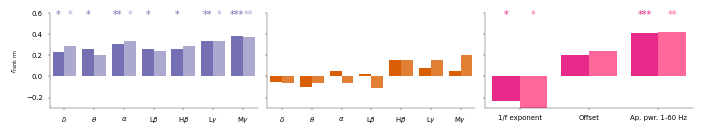

In [8]:
barplot_biomarkers(df_corr, ylim=(-.3, .6), figsize=(7, 1.3))

In [9]:
kinds = ['normalized']
df_corr_norm = get_correlation_df_multi(dataframes, kinds,
                                   remove_ties=True,
                                   n_perm=n_perm, corr_methods=['withinRank'],
                                   bands=BANDS+['gamma_mid'])

100%|██████████| 10000/10000 [00:22<00:00, 435.29it/s]



normalized:
off:
$\delta$: rho=-0.21, p=0.05
$\theta$: rho=-0.10, p=0.3
$\alpha$: rho=-0.00, p=0.93
L$\beta$: rho=0.10, p=0.42
H$\beta$: rho=0.18, p=0.14
L$\gamma$: rho=0.15, p=0.17
M$\gamma$: rho=0.08, p=0.48
on:
$\delta$: rho=-0.24, p=0.14
$\theta$: rho=-0.24, p=0.13
$\alpha$: rho=0.02, p=0.81
L$\beta$: rho=0.11, p=0.48
H$\beta$: rho=0.24, p=0.11
L$\gamma$: rho=0.24, p=0.09
M$\gamma$: rho=-0.02, p=0.97


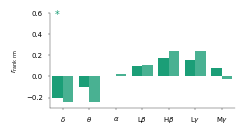

In [10]:
barplot_biomarkers(df_corr_norm, ylim=(-.3, .6), figsize=(2.4, 1.3))

### Peak probability

In [11]:
def get_peak_probability(df, bands=BANDS,
                        #  asymmetric_subjects=True,
                         project='all', hue='cond'):
    plot_dic = cfg.PLOT_LABELS_SHORT
    band_dic = cfg.BAND_NAMES_GREEK_SHORT

    df = dataframes['df_per'].copy()
    df = df[(df.project == 'all')]
    # remove subject where asymmetry switches between On and Off
    # if asymmetric_subjects is not None:
    #     df = df[df.asymmetric_subjects == asymmetric_subjects]
    # only include consistent asymmetry for ON subjects to
    # exclude possible LDOPA side effects
    df = df[(df.cond == 'off') |
            (df.dominant_side_consistent & (df.cond == 'on'))]
    # remove subjects without fooof fit
    subs_no_fit = df[df.fm_has_model.isna()].subject.unique()
    df = df[~df.subject.isin(subs_no_fit)]

    band_cols = [f'{band}_fm_powers_max_log' for band in bands]
    band_nmes = [band_dic[band] for band in bands]
    band_cols += ['fm_exponent', 'fm_offset_log']
    band_nmes += ['1/f', plot_dic['fm_offset_log']]

    assert len(band_cols) == len(band_nmes), f'{set(band_cols) - set(band_nmes)}'

    if hue == 'cond':
        hue_order = ['off', 'on']
    elif hue == 'severity':
        hue = f"patient_symptom_dominant_side_BR_{cond}"

    df_peaks = []
    for cond in hue_order:
        df_hue = df[df[hue] == cond]
        color = cfg.COLOR_DIC['periodic'] if cond == 'off' else cfg.COLOR_DIC['periodic2']
        # remove subject with only one condition
        subject_counts = df_hue.subject.value_counts()
        valid_subjects = subject_counts[subject_counts == 2].index
        df_hue = df_hue[df_hue.subject.isin(valid_subjects)]
        print(f'\n{cond}: ')
        for i, x in enumerate(band_cols):
            sample_size = df_hue[x].notna().sum()
            if 'power' in x:
                n_peaks = (df_hue[x] > 0).sum()
            elif x in ['fm_exponent', 'fm_offset_log']:
                # Aperiodic values can be negative
                n_peaks = (df_hue[x] != 0).sum()
                color = cfg.COLOR_DIC['periodicAP'] if cond == 'off' else cfg.COLOR_DIC['periodicAP2']
            probability = n_peaks / sample_size * 100
            dic = {'project': project, 'probability': probability,
                   'color': color,
                    'band_col': x, 'band_nme': band_nmes[i],
                    'sample_size': sample_size, 'cond': cond}
            df_peaks.append(dic)
            print(f'{band_nmes[i]}: {probability:.1f}%')
    df_peaks = pd.DataFrame(df_peaks)
    return df_peaks

In [12]:
def barplot_peaks(df_peaks, ylim=(0, 100)):
    hue_order = [cond for cond in cfg.COND_ORDER
                 if cond in df_peaks.cond.unique()]
    colors_off = df_peaks[df_peaks.cond == 'off'].color.to_list()
    colors_on = df_peaks[df_peaks.cond == 'on'].color.to_list()

    fig, ax = plt.subplots(1, 1, figsize=(2.3, 1.5), sharey=True)

    sns.barplot(df_peaks, ax=ax, y='probability', x='band_nme', hue='cond',
                hue_order=hue_order, legend=True)
    for bars, colors in zip(ax.containers, (colors_off, colors_on)):
        for bar, color in zip(bars, colors):
            bar.set_facecolor(color)
    handles = [Patch(facecolor=cfg.COLOR_DIC['all']), Patch(facecolor=cfg.COLOR_DIC['all2'])]
    handles = [Patch(facecolor=cfg.COLOR_DIC['periodic']), Patch(facecolor=cfg.COLOR_DIC['periodic2'])]
    ax.legend(handles, hue_order,
            #   loc='upper right'
              )
    ax.set_ylim(ylim)
    ax.set_xlabel('Space label', alpha=0)
    ax.set_ylabel('Fit probability [%]')
    fname = f'Figure5/ch_dist_sweet/peak_probability_consistent_subs'
    plt.tight_layout()
    _save_fig(fig, fname, SAVE_DIR, close=False,
              transparent=True, bbox_inches=None)


off: 
$\delta$: 3.5%
$\theta$: 46.5%
$\alpha$: 28.8%
L$\beta$: 52.0%
H$\beta$: 69.7%
L$\gamma$: 17.7%
M$\gamma$: 5.6%
1/f: 100.0%
Offset: 100.0%

on: 
$\delta$: 10.0%
$\theta$: 60.0%
$\alpha$: 26.7%
L$\beta$: 35.6%
H$\beta$: 60.0%
L$\gamma$: 22.2%
M$\gamma$: 6.7%
1/f: 100.0%
Offset: 100.0%


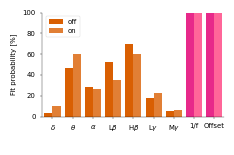

In [13]:
df_peaks = get_peak_probability(dataframes, hue='cond', bands=BANDS+['gamma_mid'])
barplot_peaks(df_peaks, ylim=(0, 100))

# Supplementary Figure Adjacent Channels

In [14]:
ch_choice = 'ch_adj_beta_high_max_off'
dataframes = get_dfs(ch_choice, equalize_subjects_norm_abs=True)

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

In [15]:
kinds = ['absolute', 'periodic', 'periodicAP']
df_corr = get_correlation_df_multi(dataframes, kinds,
                                   remove_ties=True,
                                   n_perm=n_perm, corr_methods=['withinRank'],
                                   bands=BANDS+['gamma_mid'])

100%|██████████| 10000/10000 [00:19<00:00, 519.39it/s]



absolute:
off:
$\delta$: rho=0.27, p=0.02
$\theta$: rho=0.19, p=0.11
$\alpha$: rho=0.30, p=0.01
L$\beta$: rho=0.30, p=0.01
H$\beta$: rho=0.25, p=0.04
L$\gamma$: rho=0.25, p=0.04
M$\gamma$: rho=0.30, p=0.01
on:
$\delta$: rho=0.15, p=0.33
$\theta$: rho=0.19, p=0.15
$\alpha$: rho=0.23, p=0.1
L$\beta$: rho=0.28, p=0.06
H$\beta$: rho=0.32, p=0.03
L$\gamma$: rho=0.45, p=0.002
M$\gamma$: rho=0.40, p=0.01

periodic:
off:
$\delta$: rho=-0.04, p=0.7
$\theta$: rho=-0.12, p=0.3
$\alpha$: rho=-0.04, p=0.68
L$\beta$: rho=0.09, p=0.49
H$\beta$: rho=0.30, p=0.01
L$\gamma$: rho=0.32, p=0.01
M$\gamma$: rho=0.17, p=0.16
on:
$\delta$: rho=-0.19, p=0.16
$\theta$: rho=-0.02, p=0.97
$\alpha$: rho=-0.15, p=0.3
L$\beta$: rho=0.02, p=0.92
H$\beta$: rho=0.45, p=0.002
L$\gamma$: rho=0.62, p=0.0002
M$\gamma$: rho=0.53, p=0.0003

periodicAP:
off:
1/f exponent: rho=-0.19, p=0.09
Offset: rho=0.22, p=0.05
Ap. pwr. 1-60 Hz: rho=0.32, p=0.005
on:
1/f exponent: rho=-0.32, p=0.03
Offset: rho=0.06, p=0.75
Ap. pwr. 1-60 Hz

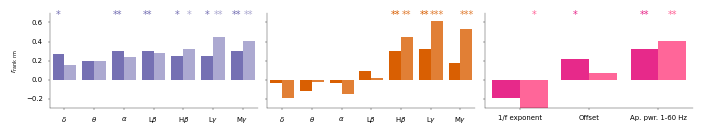

In [16]:
barplot_biomarkers(df_corr, ylim=(-.3, .7), figsize=(7, 1.3))

In [17]:
# df_peaks = get_peak_probability(dataframes, hue='severity', bands=BANDS+['gamma_mid', 'gamma'])
# barplot_peaks(df_peaks, ylim=(0, 100))

In [18]:
# def get_correlation_df_combined(dataframes,
#                              kinds=['absolute', 'periodic'],
#                              corr_methods=['withinRank'],
#                              asymmetric_subjects=True,
#                              project='all',
#                              conds=['off', 'on'], n_perm=10000):
#     """Get dataframe to plot barplot."""
#     # plot_dic = cfg.PLOT_LABELS_SHORT
#     band_dic = cfg.BAND_NAMES_GREEK

#     df_corrs = []
#     for kind in kinds:
#         # if kind == 'normalized':
#         #     df = dataframes['df_norm'].copy()
#         #     df = df[(df.project == 'all')]
#         #     # remove subject where asymmetry switches between On and Off
#         #     if asymmetric_subjects is not None:
#         #         df = df[df.asymmetric_subjects == asymmetric_subjects]
#         #     band_cols = [f'{band}_abs_max5Hz_log' for band in bands]
#         #     band_nmes = [band_dic[band] for band in bands]
#         if kind == 'absolute':
#             df = dataframes['df_abs'].copy()
#             df = df[(df.project == 'all')]
#             # remove subject where asymmetry switches between On and Off
#             if asymmetric_subjects is not None:
#                 df = df[df.asymmetric_subjects == asymmetric_subjects]
#             band_cols = [f'{band}_abs_max5Hz_log' for band in ['gamma_mid']]
#             band_nmes = [band_dic[band] for band in ['gamma_mid']]
#             # Add combined feature
#             # rank_cols = ['alpha_abs_min_log', 'gamma_mid_abs_mean_log',
#             #              'alpha_abs_max5Hz_log', 'gamma_mid_abs_max5Hz_log',
#             #              'UPDRS_III', 'UPDRS_bradyrigid_contra']
#             # df = _rank_df(df, rank_cols)
#             # df, combined = _combine_bands(df, ['alpha_abs_min_log', 'gamma_mid_abs_mean_log'], np.sum)
#             # band_cols += ['alpha_abs_min_log', 'gamma_mid_abs_mean_log', combined]
#             # band_nmes += ['A min.', 'Gamma Mean',
#             #               'A+M']
#             # df, combined = _combine_bands(df, ['alpha_abs_max5Hz_log', 'gamma_mid_abs_max5Hz_log'], np.sum)
#             # band_cols += [combined]
#             # band_nmes += ['A+M Peak']
#         elif kind == 'periodic':
#             df = dataframes['df_abs'].copy()
#             df = df[(df.project == 'all')]
#             # remove subject where asymmetry switches between On and Off
#             if asymmetric_subjects is not None:
#                 df = df[df.asymmetric_subjects == asymmetric_subjects]
#             # remove subjects without fooof fit
#             subs_no_fit = df[df.fm_has_model.isna()].subject.unique()
#             df = df[~df.subject.isin(subs_no_fit)]

#             # band_cols = [f'{band}_fm_powers_max_log' for band in bands]
#             # band_nmes = [band_dic[band] for band in bands]

#             # Add combined feature offset - 1/f
#             # rank_cols = ['fm_exponent', 'fm_offset_log',
#                         #  'UPDRS_III',
#                         #  'UPDRS_bradyrigid_contra']
#             # df = _rank_df(df, rank_cols)
#             # df, combined = _combine_bands(df, ['fm_exponent_rank', 'fm_offset_log_rank'], np.diff)

#             # Add apperiodic power
#             def ap_pwr(df, f_low=5, f_high=95):
#                 # fm limits all projects
#                 ap_pwr = df.fm_psd_ap_fit_log
#                 freqs = df.fm_freqs
#                 mask = (freqs >= f_low) & (freqs <= f_high)
#                 return ap_pwr[mask].sum()
#             # df_per = df_abs.dropna(subset=['fm_has_model', 'fm_psd_ap_fit_log'])
#             df['ap_power'] = df.apply(ap_pwr, f_low=1, f_high=60, axis=1)


#             band_cols = [
#                 # 'fm_exponent', 'fm_offset_log',
#                         #   combined,
#                           'ap_power'
#                           ]
#             band_nmes = [
#                 # '1/f', plot_dic['fm_offset_log'],
#                         #   'Offset - 1/f',
#                           'Ap. power'
#                           ]

#         assert len(band_cols) == len(band_nmes), f'{set(band_cols) - set(band_nmes)}'

#         for cond in conds:
#             df_cond = df[df.cond == cond]

#             # remove subject with only one condition
#             subject_counts = df_cond.subject.value_counts()
#             valid_subjects = subject_counts[subject_counts == 2].index
#             df_cond = df_cond[df_cond.subject.isin(valid_subjects)]
#             for i, x in enumerate(band_cols):
#                 if 'offset' in x or 'exponent' in x or 'ap_power' in x:
#                     color = cfg.COLOR_DIC['periodicAP'] if cond == 'off' else cfg.COLOR_DIC['periodicAP2']
#                 else:
#                     color = cfg.COLOR_DIC[kind] if cond == 'off' else cfg.COLOR_DIC[f'{kind}2']
#                 for corr_method in corr_methods:
#                     if corr_method == 'spearman':
#                         use_corr_method = corr_method
#                         y = 'UPDRS_III'
#                         df_rho = _average_hemispheres(df_cond, x, y)
#                     elif corr_method == 'withinRank':
#                         df_rho = df_cond
#                         if '_rank' in x:
#                             # use within method for ranked data
#                             use_corr_method = 'within'
#                             y = 'UPDRS_bradyrigid_contra_rank'
#                         else:
#                             use_corr_method = corr_method
#                             y = 'UPDRS_bradyrigid_contra'
#                     corr_kwargs = dict(df_rho=df_rho, x=x, y=y,
#                                     corr_method=use_corr_method, n_perm=n_perm)
#                     rho, sample_size, label, _, _ = _corr_results(**corr_kwargs)
#                     if rho is None:
#                         raise ValueError(f'No correlation found for {corr_kwargs}')
#                         # continue
#                     pval = float(label.split(' ')[-1].strip('p='))
#                     dic = {'project': project, 'rho': rho,
#                             'band_col': x, 'band_nme': band_nmes[i],
#                             'kind': kind, 'color': color,
#                             'sample_size': sample_size, 'pval': pval,
#                             'n_perm': n_perm, 'cond': cond,
#                             'corr_method': corr_method, 'y': y}
#                     df_corrs.append(dic)
#     df_corrs = pd.DataFrame(df_corrs)
#     return df_corrs


# def abs_pwr_sum4(df, f_1=5, f_2=95, f_3=0, f_4=0):
#     # fm limits all projects
#     ap_pwr = df.psd_log
#     freqs = df.psd_freqs
#     mask = ((freqs >= f_1) & (freqs <= f_2)) | ((freqs >= f_3) & (freqs <= f_4))
#     return (ap_pwr[mask]).sum()


# def abs_pwr_sum2(df, f_1=5, f_2=95):
#     # fm limits all projects
#     ap_pwr = df.psd_log
#     freqs = df.psd_freqs
#     mask = ((freqs >= f_1) & (freqs <= f_2))
#     return (ap_pwr[mask]).sum()


# def get_correlation_df_sums(dataframes,
#                              kinds=['absolute', 'periodic'],
#                              corr_methods=['withinRank'],
#                              asymmetric_subjects=True,
#                              project='all',
#                              conds=['off', 'on'], n_perm=10000):
#     """Get dataframe to plot barplot."""
#     plot_dic = cfg.PLOT_LABELS
#     # band_dic = cfg.BAND_NAMES_GREEK

#     df_corrs = []
#     for kind in kinds:
#         if kind == 'absolute':
#             df = dataframes['df_abs'].copy()
#             df = df[(df.project == 'all')]
#             # remove subject where asymmetry switches between On and Off
#             if asymmetric_subjects is not None:
#                 df = df[df.asymmetric_subjects == asymmetric_subjects]

#             band_cols = [f'{band}_abs_max5Hz_log' for band in ['gamma_mid']]
#             band_nmes = [plot_dic[band_col] for band_col in band_cols]

#             # # int_1_13 = 'int_1_13'
#             # # df[int_1_13] = df.apply(abs_pwr_sum2, f_1=1, f_2=13, axis=1)
#             # # int_13_30 = 'int_13_30'
#             # # df[int_13_30] = df.apply(abs_pwr_sum2, f_1=13, f_2=30, axis=1)
#             # int_30_100 = 'int_30_100'
#             # df[int_30_100] = df.apply(abs_pwr_sum2, f_1=30, f_2=100, axis=1)
#             # int_1_100 = 'int_1_100'
#             # df[int_1_100] = df.apply(abs_pwr_sum2, f_1=1, f_2=100, axis=1)
#             # int_noBeta = 'int_noBeta'
#             # df[int_noBeta] = df.apply(abs_pwr_sum4, f_1=1, f_2=13, f_3=30, f_4=100, axis=1)
#             # band_cols += [
#             #     # int_1_13, int_13_30,
#             #     int_30_100, int_1_100, int_noBeta]

#             # # int_1_13_str = r'$\int_{1\text{ Hz}}^{13\text{ Hz}}\text{log(PSD)}$'
#             # int_1_100_str = r'$\int_{1\text{ Hz}}^{100\text{ Hz}}\text{log(PSD)}$'
#             # # int_13_30_str = r'$\int_{13\text{ Hz}}^{30\text{ Hz}}\text{log(PSD)}$'
#             # int_30_100_str = r'$\int_{30\text{ Hz}}^{100\text{ Hz}}\text{log(PSD)}$'
#             # int_noBeta_str = r'$\int_{1\text{ Hz}}^{13\text{ Hz}}\text{log(PSD)} + \int_{30\text{ Hz}}^{100\text{ Hz}}\text{log(PSD)}$'
#             # band_nmes += [
#             #     # int_1_13_str, int_13_30_str,
#             #     int_30_100_str, int_1_100_str, int_noBeta_str]
#         elif kind == 'periodic':
#             df = dataframes['df_abs'].copy()
#             df = df[(df.project == 'all')]
#             # remove subject where asymmetry switches between On and Off
#             if asymmetric_subjects is not None:
#                 df = df[df.asymmetric_subjects == asymmetric_subjects]
#             # remove subjects without fooof fit
#             subs_no_fit = df[df.fm_has_model.isna()].subject.unique()
#             df = df[~df.subject.isin(subs_no_fit)]

#             # Add combined feature offset - 1/f
#             # rank_cols = ['fm_exponent', 'fm_offset_log',
#             #              'UPDRS_III',
#             #              'UPDRS_bradyrigid_contra']
#             # df = _rank_df(df, rank_cols)
#             # df, combined = _combine_bands(df, ['fm_exponent_rank', 'fm_offset_log_rank'], np.diff)

#             # Add apperiodic power
#             def ap_pwr(df, f_low=5, f_high=95):
#                 # fm limits all projects
#                 ap_pwr = df.fm_psd_ap_fit_log
#                 freqs = df.fm_freqs
#                 mask = (freqs >= f_low) & (freqs <= f_high)
#                 return ap_pwr[mask].sum()
#             # df_per = df_abs.dropna(subset=['fm_has_model', 'fm_psd_ap_fit_log'])
#             df['ap_power'] = df.apply(ap_pwr, f_low=1, f_high=60, axis=1)


#             band_cols = [
#                 # 'fm_exponent', 'fm_offset_log',
#                         #   combined,
#                           'ap_power'
#                           ]
#             band_nmes = [
#                 # '1/f', plot_dic['fm_offset_log'],
#                         #   'Offset - 1/f',
#                           'Ap. pwr. 1-60 Hz'
#                           ]

#         assert len(band_cols) == len(band_nmes), f'{set(band_cols) - set(band_nmes)}'

#         for cond in conds:
#             df_cond = df[df.cond == cond]

#             # remove subject with only one condition
#             subject_counts = df_cond.subject.value_counts()
#             valid_subjects = subject_counts[subject_counts == 2].index
#             df_cond = df_cond[df_cond.subject.isin(valid_subjects)]
#             for i, x in enumerate(band_cols):
#                 if 'offset' in x or 'exponent' in x or 'ap_power' in x:
#                     color = cfg.COLOR_DIC['periodicAP'] if cond == 'off' else cfg.COLOR_DIC['periodicAP2']
#                 else:
#                     color = cfg.COLOR_DIC[kind] if cond == 'off' else cfg.COLOR_DIC[f'{kind}2']
#                 for corr_method in corr_methods:
#                     if corr_method == 'spearman':
#                         use_corr_method = corr_method
#                         y = 'UPDRS_III'
#                         df_rho = _average_hemispheres(df_cond, x, y)
#                     elif corr_method == 'withinRank':
#                         df_rho = df_cond
#                         if '_rank' in x:
#                             # use within method for ranked data
#                             use_corr_method = 'within'
#                             y = 'UPDRS_bradyrigid_contra_rank'
#                         else:
#                             use_corr_method = corr_method
#                             y = 'UPDRS_bradyrigid_contra'
#                     corr_kwargs = dict(df_rho=df_rho, x=x, y=y,
#                                     corr_method=use_corr_method, n_perm=n_perm)
#                     rho, sample_size, label, _, _ = _corr_results(**corr_kwargs)
#                     if rho is None:
#                         raise ValueError(f'No correlation found for {corr_kwargs}')
#                         # continue
#                     pval = float(label.split(' ')[-1].strip('p='))
#                     dic = {'project': project, 'rho': rho,
#                             'band_col': x, 'band_nme': band_nmes[i],
#                             'kind': kind, 'color': color,
#                             'sample_size': sample_size, 'pval': pval,
#                             'n_perm': n_perm, 'cond': cond,
#                             'corr_method': corr_method, 'y': y}
#                     df_corrs.append(dic)
#     df_corrs = pd.DataFrame(df_corrs)
#     return df_corrs

In [19]:
# def barplot_biomarkers_combined(df_corrs, extension='', figsize=(7, 1.5), ylim=None):

#     kinds = df_corrs.kind.unique()

#     hue_order = [cond for cond in cfg.COND_ORDER
#                  if cond in df_corrs.cond.unique()]

#     n_cols = len(kinds)
#     fig, axes = plt.subplots(1, n_cols, figsize=figsize, sharey=True,
#                             #  width_ratios=[3, 1]
#                              )
#     axes = _axes2d(axes, 1, n_cols)
#     for i, kind in enumerate(kinds):
#         ax = axes[0, i]
#         df_kind = df_corrs[df_corrs.kind == kind]
#         band_nmes = df_kind.band_nme.unique()
#         # palette = [cfg.COLOR_DIC[kind], cfg.COLOR_DIC[kind + '2']]
#         sns.barplot(df_kind, ax=ax, y='rho', x='band_nme', hue='cond',
#                     hue_order=hue_order,
#                     # palette=palette,
#                     legend=False)
#         # sns.move_legend(ax, "best", title=None)
#         ax.set_ylim(ylim)
#         # xlabel = '5 Hz Peak Mean' if i < 2 else 'Periodic peak power'
#         ax.set_xlabel(None)
#         # indicate significance
#         _, ymax = ax.get_ylim()
#         for i, cond in enumerate(hue_order):
#             for j, band_col in enumerate(band_nmes):
#                 bar = ax.containers[i][j]
#                 mask = (df_kind.cond == cond) & (df_kind.band_nme == band_col)
#                 color = df_kind[mask].color.values[0]
#                 bar.set_facecolor(color)
#                 df_band = df_kind[(df_kind.band_nme == band_col) &
#                                   (df_kind.cond == cond)]
#                 # rho = df_band.rho.values[0]
#                 pvalue = df_band.pval.values[0]
#                 text = convert_pvalue_to_asterisks(pvalue)
#                 x_bar = bar.get_x() + bar.get_width() / 2
#                 ax.annotate(text,
#                             xy=(x_bar, ymax),
#                             va='bottom',
#                             ha='center',
#                             fontsize=FONTSIZE_ASTERISK,
#                             color=color
#                             )

#     axes[0, 0].set_ylabel(r"$r_{\text{rank rm}}$")
#     # handles = [Patch(facecolor=cfg.COLOR_DIC['all']), Patch(facecolor=cfg.COLOR_DIC['all2'])]
#     # axes[0].legend(handles, hue_order, loc='upper right')
#     n_perm = df_corrs.n_perm.unique()[0]
#     kind_str = '_'.join(df_corrs.kind.unique())
#     fname = f'Figure5/ch_dist_sweet/biomarkers_combined_{kind_str}_nperm={n_perm}{extension}'
#     plt.tight_layout()
#     _save_fig(fig, fname, SAVE_DIR, close=False,
#               transparent=True, bbox_inches=None)


In [20]:
# df_comb = get_correlation_df_sums(dataframes, n_perm=n_perm, corr_methods=['withinRank'])

In [21]:
# barplot_biomarkers_combined(df_comb, figsize=(1.7, 1),
#                             ylim=(0, 0.6)
#                             )

In [22]:
# barplot_biomarkers_combined(df_comb[df_comb.kind=='absolute'], figsize=(1, 1),
#                             ylim=(0, 0.6)
#                             )

In [23]:
# barplot_biomarkers_combined(df_comb[df_comb.kind=='periodic'], figsize=(1, 1),
#                             ylim=(0, 0.6)
#                             )